## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole, joule, meter, pascals, kilojoule
from openmm.unit import Quantity, Unit
import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm


/tmp/ipykernel_1052567/2833670413.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.



****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



## Concentration profiles

In [2]:
##Some constants
k= 1.0457*(kilojoule_per_mole/nanometer**2)
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant
vanthoff_nu=2
temp=300*kelvin

In [3]:
##Function to symmetrize to the median of the density plot
def conc_prof_hw(filename):
    xz,yz = np.loadtxt(filename,comments=["@", "#"],unpack=True)
    ## Assign units to number density values and convert them to concentration units mol/L 
    yz=(yz/nanometer**3)/(AVOGADRO_CONSTANT_NA)
    yz=yz.in_units_of(mole/litre)/2
    halfz=int((len(yz)/2)-1)
    ## Average concentration from both sides of the middle of the box (7.2 nm) 
    yz1=yz[:halfz+1]
    yz2=yz[halfz:-1]
    yz2=yz2[::-1]
    yz1 = np.array(yz1)
    yz2 = np.array(yz2)
    av_y=[(a+b)/2 for a,b in zip(yz1,yz2)]
    av_C=av_y[::-1]
    av_C=np.array(av_C)*(mole/litre)
    xz2=np.array(xz[:halfz+1])*nanometer
    return xz2, av_C

## Function to calculate Osmotic Pressure
def calculate_pi(z_coordinates,z_concentrations,pi_1:Quantity,springk,vanthoff=vanthoff_nu):
    
    z_coordinates=z_coordinates[::-1]
    z_concentrations=z_concentrations[::-1]
    delta_z=z_coordinates[0]-z_coordinates[1]
    pi_results = []

    ## Calculate Pi_2 stepwise
    for i in range(len(z_concentrations)-1):
        #print(pi_1)
        
        ## Calculate the average of concentration
        phi_avg = (z_concentrations[i+1] + z_concentrations[i]) / 2
        #print(phi_avg)
        
        ## Calculate the average of z coordinates
        z_avg = (z_coordinates[i+1] + z_coordinates[i]) / 2
        #print(z_avg)
        
        ## Calculate Pi_2
        fact1=vanthoff*phi_avg*z_avg*springk*delta_z
        fact2=(fact1.in_units_of(joule/meter**3)).in_units_of(pascals)
        mult_fact=fact2.in_units_of(bar)
        pi_2 = pi_1 + mult_fact
        pi_results.append(pi_2._value)

        ## Set pi_2 as the new pi_1 for next iteration
        pi_1=pi_2


    # #print(f'phi_avg final = {phi_avg}, z_avg final = {z_avg}, fact1 = {fact1}, pi_2 = {pi_2}')
    return z_concentrations, pi_results

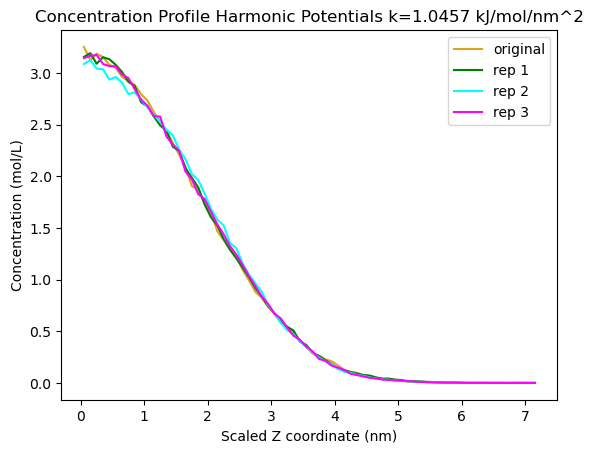

In [4]:
original_x, original_y = conc_prof_hw("density_hwl.xvg")
r1_x, r1_y = conc_prof_hw("density_hwr1.xvg")
r2_x, r2_y = conc_prof_hw("density_hwr2.xvg")
r3_x, r3_y = conc_prof_hw("density_hwr3.xvg")

##Plot concentration gradient
plt.plot(original_x, original_y, c='goldenrod', label='original')
plt.plot(r1_x, r1_y, c='green', label='rep 1')
plt.plot(r2_x, r2_y, c='cyan', label='rep 2')
plt.plot(r3_x, r3_y, c='magenta', label='rep 3')
plt.xlabel("Scaled Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.xticks(np.arange(0, 7.2, 1.0))
plt.yticks(np.arange(0, 3.5, 0.5))
plt.title('Concentration Profile Harmonic Potentials k=1.0457 kJ/mol/nm^2')
plt.legend()
plt.show()

## Fittings

In [5]:
import scipy.optimize as optimization
from scipy.optimize import leastsq

In [6]:
##Remove unit from concentration profile
oriy=original_y
oriy=oriy.value_in_unit(oriy.unit)
print(oriy)

[3.25403387e+00 3.12707736e+00 3.18929360e+00 3.15584619e+00
 3.08104306e+00 3.05155189e+00 2.96343953e+00 2.92423836e+00
 2.88683887e+00 2.79620664e+00 2.73578793e+00 2.62393817e+00
 2.53115140e+00 2.44159853e+00 2.32435616e+00 2.20747497e+00
 2.09238716e+00 1.90429790e+00 1.87804478e+00 1.73706501e+00
 1.65218656e+00 1.46877171e+00 1.38389741e+00 1.29506687e+00
 1.22241829e+00 1.09294606e+00 9.91889801e-01 8.81839650e-01
 8.23935407e-01 7.35466037e-01 6.66414596e-01 5.83696918e-01
 5.40540338e-01 4.88751445e-01 4.15744600e-01 3.54246120e-01
 2.84835587e-01 2.64335817e-01 2.28731369e-01 2.09670456e-01
 1.69031253e-01 1.28032129e-01 1.07532442e-01 9.78223564e-02
 7.69632044e-02 6.76124598e-02 5.50250340e-02 3.59640381e-02
 3.63237109e-02 2.12187833e-02 1.94206271e-02 1.36663611e-02
 1.51049276e-02 1.33067298e-02 4.67533077e-03 6.11390143e-03
 3.23676426e-03 2.15784270e-03 1.43856651e-03 1.43856360e-03
 7.19283254e-04 3.59640797e-04 1.07892280e-03 7.19281593e-04
 7.19281593e-04 7.192832

In [7]:
#coefficients along a line of constant chemical potential of the water (OBTAINED FROM SI OF PAPER)
A_M=1.7964*(mole/litre)**(-1/2)
B_M=1.9247*(mole/litre)**(-1/2)
a1_M=9.3393E-2*(mole/litre)**(-1)
a2_M=3.4572E-2*(mole/litre)**(-2)

In [8]:
##WRITING EQUATION 12 FROM PAPER
def fitting_lstsq(variables,y_data):
    A_M=1.7964*(mole/litre)**(-1/2)
    B_M=1.9247*(mole/litre)**(-1/2)
    c_s=y_data.value_in_unit(y_data.unit)
    sqrt_cs=np.sqrt(c_s)
    c_max=c_s[0]
    sqrt_cmax=np.sqrt(c_max)
    A_fit=A_M.value_in_unit(A_M.unit)
    B_fit=B_M.value_in_unit(B_M.unit)
    # alphai=alphai.value_in_unit(alphai.unit)
    with np.errstate(divide='ignore', invalid='ignore'):
        term1 = np.true_divide(c_s,c_max)
        term1[term1 == np.inf] = 0
        term1 = np.nan_to_num(term1)

    t2_denom1=np.add(1,(np.multiply(B_fit,sqrt_cmax)))
    t2_frac1=np.divide(sqrt_cmax,t2_denom1)
    t2_denom2=np.add(1,(np.multiply(B_fit,sqrt_cs)))
    t2_frac2=np.divide(sqrt_cs,t2_denom2)
    t2_inside=t2_frac1-t2_frac2
    term2=A_fit*t2_inside

    left_terms=np.add(term1,term2)
    
    i_max=[1,2]
    alphas=[variables[0],variables[1]]
    t3=sum(ai*((c_s**i)-(c_max**i)) for ai,i in zip(alphas,i_max))

    objective=np.add(left_terms, t3)
 
    return -objective

In [9]:
##FITTING
variables=[9.3393E-2,3.4572E-2]
out=optimization.leastsq(fitting_lstsq,variables,args=(original_y))
print(out[0])
newy=fitting_lstsq(out[0],original_y)
print(newy)

[ 2.48988665 -0.69842337]
[ 2.25403387e+00  1.91314850e+00  2.07740999e+00  1.98843611e+00
  1.79506406e+00  1.72095845e+00  1.50672731e+00  1.41487202e+00
  1.32922156e+00  1.12968974e+00  1.00298689e+00  7.81746627e-01
  6.11326467e-01  4.58112199e-01  2.74233616e-01  1.09754094e-01
 -3.38608482e-02 -2.29496335e-01 -2.52955873e-01 -3.62866269e-01
 -4.16008449e-01 -4.97570442e-01 -5.20004129e-01 -5.33185456e-01
 -5.36186191e-01 -5.24344858e-01 -4.99996165e-01 -4.58708499e-01
 -4.30930926e-01 -3.80652049e-01 -3.35034758e-01 -2.73398537e-01
 -2.38391070e-01 -1.93996523e-01 -1.27474397e-01 -6.85519993e-02
 -1.83431324e-04  2.00822239e-02  5.49418463e-02  7.32385309e-02
  1.10598801e-01  1.44112452e-01  1.58085588e-01  1.63724792e-01
  1.72829593e-01  1.75111319e-01  1.75663531e-01  1.67969144e-01
  1.68251690e-01  1.48679892e-01  1.44881080e-01  1.29125303e-01
  1.33683009e-01  1.27906740e-01  8.22829183e-02  9.32514083e-02
  6.84292323e-02  5.48480235e-02  4.30391307e-02  4.30390761e-02

In [10]:
# popt, pcov=optimization.curve_fit(fitting_lstsq, xdata=original_x, ydata=original_y,p0=(9.3393E-2,2),bounds=(0,3.5))
# print("Parameter estimation results:")
# print("p1 = ",popt[0]," | p2 = ",popt[1])
# print("--------------------------")
# print("Covariance matrix of the estimate:")
# print(pcov)
# print("--------------------------")
# p1 = popt[0]
# p2 = popt[1]
# residuals = oriy - fitting_lstsq(original_y,p1,p2)
# fres = sum(residuals**2)

# print("Residuals sum of squares:")
# print(fres)
# print("--------------------------")
# newy=fitting_lstsq(original_y,p1,p2)
# print(newy)

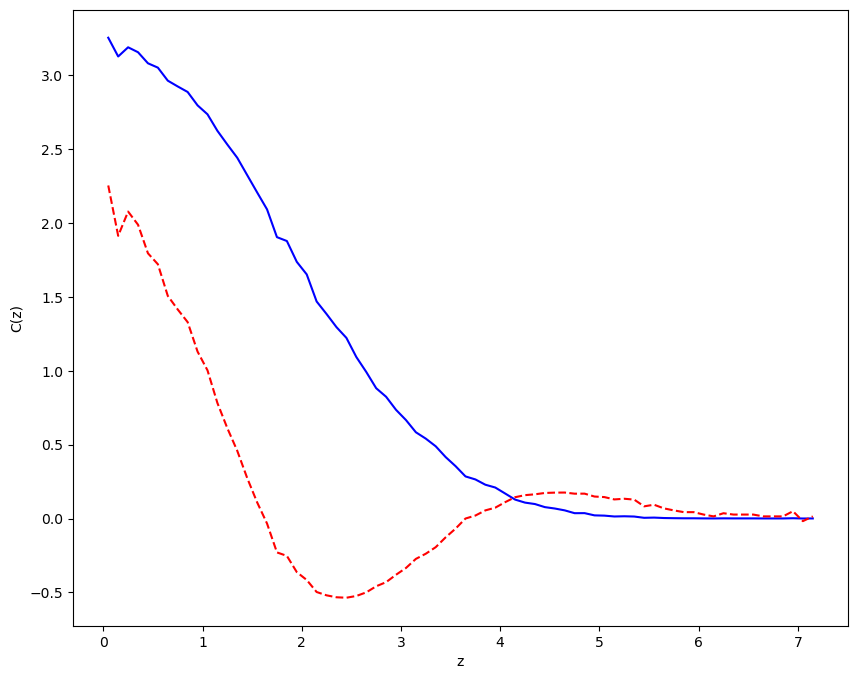

In [11]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(original_x, original_y, 'b')
plt.plot(original_x, newy, 'r--')
plt.xlabel('z')
plt.ylabel('C(z)')
plt.show()

## Calculating osmotic values

In [12]:
## Calculate ideal osmotic pressure at max concentration to have an idea of what the value should be close to  
def osmotic_values(molality, conc_vals, osmpress_vals,repnum):
    vant_hoff=2
    T=300*kelvin

    if repnum == 0:
        print("Data for original run")
    else:
        print("Data for replicate #",repnum)

    if molality == 1:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-0.976*(mole/litre)))
        print(f'Osmotic values for ~1m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar
    
    if molality == 2:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-1.923*(mole/litre)))
        print(f'Osmotic values for ~2m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar
    
    if molality == 3:
        molarity= min(conc_vals[1:], key=lambda x:abs(x-2.823*(mole/litre)))
        print(f'Osmotic values for ~3m, molar concentration = {molarity}')
        for cM,opress in zip(conc_vals[1:],osmpress_vals):
            if cM == molarity:
                osm_press_obs=opress*bar

    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    print(f"Osmotic Pressure Ideal: {osm_press_ideal}")

    osm_coeff=osm_press_obs/osm_press_ideal

    print(f"Osmotic Pressure Observed: {osm_press_obs}, Osmotic Coefficient: {osm_coeff} \n")

    tresults = dict()

    tresults['os_pres_val'] = osm_press_obs
    tresults['os_coef_val'] = osm_coeff
    tresults['m'] = molality
    tresults['repnum'] = repnum
    
    return tresults



#### (exp_osm_coeff=0.936,molarity=0.976*(mole/litre))
#### (exp_osm_coeff=0.984,molarity=1.923*(mole/litre))
#### (exp_osm_coeff=1.045,molarity=2.823*(mole/litre))

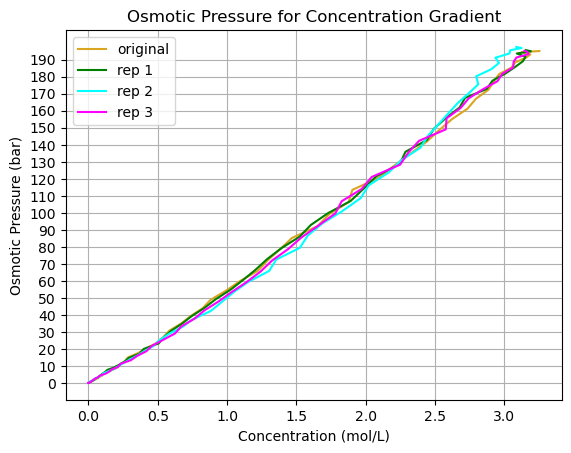

In [13]:
z_concs_o, pi_val_o = calculate_pi(original_x, original_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r1, pi_val_r1 = calculate_pi(r1_x, r1_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r2, pi_val_r2 = calculate_pi(r2_x, r2_y, pi_1=0*bar, springk=k,vanthoff=2)
z_concs_r3, pi_val_r3 = calculate_pi(r3_x, r3_y, pi_1=0*bar, springk=k,vanthoff=2)


plt.plot(z_concs_o[1:], pi_val_o, c='goldenrod', label='original')
plt.plot(z_concs_r1[1:], pi_val_r1, c='green', label='rep 1')
plt.plot(z_concs_r2[1:], pi_val_r2, c='cyan', label='rep 2')
plt.plot(z_concs_r3[1:], pi_val_r3, c='magenta', label='rep 3')
plt.xlabel("Concentration (mol/L)")
plt.ylabel("Osmotic Pressure (bar)")
plt.xticks(np.arange(0, 3.5, 0.5))
plt.yticks(np.arange(0, 200, 10))
plt.title('Osmotic Pressure for Concentration Gradient')
plt.legend()
plt.grid()
plt.show()